In [2]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from ITrackerData import ITrackerData, SubtractMean
from ITrackerModel import ITrackerModel
import cv2
from PIL import Image, ImageDraw
#import face_recognition
import os
import numpy as np
import torchvision.transforms as transforms
import csv
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-9copxr6j because the default path (/tmp/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [17]:
# Load a pre-trained version of MobileNetV2
torch_model = ITrackerModel()
# SubtractMean = SubtractMean()
# torch_model = torch.nn.DataParallel(torch_model)

# Load Weights
checkpoint = torch.load('checkpoint.pth.tar',map_location=torch.device('cpu'))
torch_model.load_state_dict(checkpoint['state_dict'])
filePath = '../vid1.MP4'
torch_model.eval()

# feature_names = ['calibration.face.distance', 'calibration.face.pitch', 'calibration.face.yaw', 'calibration.face.translation_x', 'calibration.face.translation_y', 'calibration.eyes.pitch', 'calibration.eyes.yaw', 'calibration.lookatpoint.x', 'calibration.lookatpoint.y', 'calibration.coordinates.x', 'calibration.coordinates.y', 'ModCoordinateX', 'ModCoordinateY', 'ModeyesPitch', 'ModeyesYaw', 'StringA', 'StringB', 'StringC', 'StringD', 'lighting', 'temperature', 'numberofModel', 'widthDevice', 'heightDevice', 'DistanceBetweenEyes', 'Blinks', 'calibration.lefteye.eyeBlink', 'calibration.lefteye.eyeLookDown', 'calibration.lefteye.eyeLookIn', 'calibration.lefteye.eyeLookOut', 'calibration.lefteye.eyeLookUp', 'calibration.lefteye.eyeSquint', 'calibration.lefteye.eyeWide', 'calibration.righteye.eyeBlink', 'calibration.righteye.eyeLookDown', 'calibration.righteye.eyeLookIn', 'calibration.righteye.eyeLookOut', 'calibration.righteye.eyeLookUp', 'calibration.righteye.eyeSquint', 'calibration.righteye.eyeWide', 'ignore1','ignore2', 'calibration.time.referenceTime']
device = 'iPhone XR'
device_properties = pd.read_csv('/hpc/gsin255/Documents/MLPipeline/apple_device_properties.csv')
prop = device_properties[device_properties['model'] == device].T.iloc[:,0]
scale_factor = (prop.pt_to_px*2.54)/prop.ppi
device_width = prop.width_points
device_height = prop.height_points

xgaze, ygaze = [], []
with open('../vid1.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for index,row in enumerate(csv_reader):
        if index==16:
            xgaze=np.array(row).astype(float)
        if index==17:
            ygaze=np.array(row).astype(float)
            
xgaze -= device_width/2
xgaze *= scale_factor
ygaze *= scale_factor

def loadMetadata(filename, silent = False):
    try:
        # http://stackoverflow.com/questions/6273634/access-array-contents-from-a-mat-file-loaded-using-scipy-io-loadmat-python
        if not silent:
            print('\tReading metadata from %s...' % filename)
        metadata = sio.loadmat(filename, squeeze_me=True, struct_as_record=False)
    except:
        print('\tFailed to read the meta file "%s"!' % filename)
        return None
    return metadata

MEAN_PATH = './'
faceMean = loadMetadata('mean_face_224.mat')['image_mean']
eyeLeftMean = loadMetadata('mean_left_224.mat')['image_mean']
eyeRightMean = loadMetadata('mean_right_224.mat')['image_mean']

 
countframe = -1
cap = cv2.VideoCapture(filePath)
if (cap.isOpened()== False):
    print("Error opening video stream or file")
    
predictions = []
errorx = []
errory = []

while(cap.isOpened()):
          firstFrame = True
          ret, frame = cap.read()
        #   if countframe == 4:
        #         cap.release()
          if ret == True :
            countframe = countframe + 1
            print(countframe)
            if countframe < 698:
                # countframe = 0
                image = frame
                # Convert into grayscale
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                # Convert into RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                # image = Image.fromarray(image)
                
                # Load the cascade
                face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
                left_eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_lefteye_2splits.xml')
                right_eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_righteye_2splits.xml')

                # Detect faces
                faces = face_cascade.detectMultiScale(gray, 1.1, 4)
                left_eye = left_eye_cascade.detectMultiScale(gray, 1.1, 4)
                right_eye = right_eye_cascade.detectMultiScale(gray, 1.1, 4)
                
                # FACE
                areas = [w*h for x,y,w,h in faces]
                i_biggest = np.argmax(areas)
                biggest_face = faces[i_biggest]
                (face_x, face_y, face_w, face_h) = biggest_face
                # cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)
                face = image[face_y:face_y + face_h, face_x:face_x + face_w]
                # face = cv2.resize(face, (224,224), interpolation = cv2.INTER_AREA)
                # cv2.imwrite('Face.jpg',faces)
                # print("Face saved")
                face = Image.fromarray(face)

                # GRID
                height, width = image.shape[:2]
                grid = [int(face_x*25/width), int(face_y*25/height), int((face_x+face_w)*25/width), int((face_y+face_h)*25/height)]
                grid_mask = np.zeros((25, 25))
                grid_mask[grid[0]:grid[2], grid[1]:grid[3]] = 1
                
                # resized_img = cv2.resize(image, (25,25), interpolation = cv2.INTER_AREA)
                # cv2.rectangle(resized_img, (grid[1], grid[0]), (grid[3], grid[2]), (0, 0, 255), 1) 
                # cv2.imwrite("Grid2.jpg", resized_img)
                # cv2.imwrite("Grid_gray2.jpg",grid_mask*255)
                
                # LEFT EYE
                leftmost_x = face_x+face_w
                for (left_eye_x, left_eye_y, left_eye_w, left_eye_h) in left_eye:
                    if left_eye_x>face_x and (left_eye_x+left_eye_w)<(face_x+face_w) and left_eye_y>face_y and (left_eye_y+left_eye_h)<(face_x+face_h):
                        if left_eye_x<leftmost_x:
                    # cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)
                            left_eye = image[left_eye_y:left_eye_y + left_eye_h, left_eye_x:left_eye_x + left_eye_w]
                            leftmost_x = left_eye_x
                # left_eye = cv2.resize(left_eye, (224,224), interpolation = cv2.INTER_AREA)
                # cv2.imwrite('Left_eye.jpg',left_eye)
                # print("Left eye saved")
                left_eye = Image.fromarray(left_eye)

                # RIGHT EYE
                rightmost_x = 0
                for (right_eye_x, right_eye_y, right_eye_w, right_eye_h) in right_eye:
                    if right_eye_x>face_x and (right_eye_x+right_eye_w)<(face_x+face_w) and right_eye_y>face_y and (right_eye_y+right_eye_h)<(face_x+face_h):
                    # cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)
                        if right_eye_x > rightmost_x:
                            right_eye = image[right_eye_y:right_eye_y + right_eye_h, right_eye_x:right_eye_x + right_eye_w]
                            rightmost_x = right_eye_x
                # cv2.imwrite('Right_eye.jpg',right_eye)
                # right_eye = cv2.resize(right_eye, (224,224), interpolation = cv2.INTER_AREA)
                # print("Right eye saved")

                # cv2.imwrite('Frame.jpg',frame)
                # print("Frame saved")
                right_eye = Image.fromarray(right_eye)
                

                grid_mask = grid_mask.flatten()

                imSize = (224,224)

                transformFace = transforms.Compose([
                    transforms.Resize(imSize),
                    transforms.ToTensor(),
                    SubtractMean(meanImg=faceMean),
                ])
                transformEyeL = transforms.Compose([
                    transforms.Resize(imSize),
                    transforms.ToTensor(),
                    SubtractMean(meanImg=eyeLeftMean),
                ])
                transformEyeR = transforms.Compose([
                    transforms.Resize(imSize),
                    transforms.ToTensor(),
                    SubtractMean(meanImg=eyeRightMean),
                ])
      
                imFace =  transformFace(face)
                imEyeL =  transformEyeL(left_eye)
                imEyeR =  transformEyeR(right_eye)
                faceGrid = torch.FloatTensor(grid_mask)
                imFace = torch.unsqueeze(imFace, 0)
                imEyeL = torch.unsqueeze(imEyeL, 0)
                imEyeR = torch.unsqueeze(imEyeR, 0)
                faceGrid = torch.unsqueeze(faceGrid, 0)
                # torch.tensor.expand(imFace)
                # print("shape")
                # print(face.shape, left_eye.shape,right_eye.shape, grid_mask.shape)
                # print(imFace.shape, imEyeL.shape,imEyeR.shape, faceGrid.shape)

                imFace = torch.autograd.Variable(imFace, requires_grad = False)
                imEyeL = torch.autograd.Variable(imEyeL, requires_grad = False)
                imEyeR = torch.autograd.Variable(imEyeR, requires_grad = False)
                faceGrid = torch.autograd.Variable(faceGrid, requires_grad = False)
                # imFace = self.ttransformEyeLransformFace(imFace)
            #             self.transformFace = transforms.Compose([
            # transforms.Resize(self.imSize),
            # transforms.ToTensor(),
            # SubtractMean(meanImg=self.faceMean),
        # ])
                # arr_reshaped = np.transpose(arr, (2, 1, 0))
                
                with torch.no_grad():
                    out = torch_model(imFace,
                        imEyeL,
                        imEyeR,
                        faceGrid)
                # print(out)
                # print(out.numpy())
                predictions.append(out.numpy()[0])
                # tensor_array.cpu().detach().numpy()
                errorx.append(np.abs(xgaze[countframe]-out.numpy()[0][0]))
                errory.append(np.abs(ygaze[countframe]-out.numpy()[0][1]))

                # print("Error X:", np.mean(errorx))
                # print("Error Y:",np.mean(errory))


                # pd.DataFrame(predictions).to_csv("predictions.csv", index=False)
                # pd.DataFrame(errorx).to_csv("errorx.csv", index=False)
                # pd.DataFrame(errory).to_csv("errory.csv", index=False)

                # print(out)

                # print(grid_mask)
                # # cv2.imwrite('Grid.jpg',grid_mask)
                # # image_int = np.array(255*grid_mask, np.uint8)
                # # cv2.imwrite('Grid_gray.jpg',image_int)
                
                # resized_image = cv2.resize(image, (25,25), interpolation = cv2.INTER_AREA)

                
                # cv2.rectangle(resized_image, (grid[0], grid[1]), (grid[2], grid[3]), (0, 0, 255), 2)
                # cv2.imwrite('Grid.jpg',resized_image)
                # cv2.bitwise_and('Frame.jpg', )

                # face_landmarks_list = face_recognition.face_landmarks(image)
                # pil_image = Image.fromarray(image)
                # d = ImageDraw.Draw(pil_image)
                
                # for face_landmarks in face_landmarks_list:
                  
                    # Print the location of each facial feature in this image
                    #for facial_feature in face_landmarks.keys():
                        #print("The {} in this face has the following points: {}".format(facial_feature, face_landmarks[facial_feature]))
                
                    # Let's trace out each facial feature in the image with a line!
                    # for facial_feature in face_landmarks.keys():
                        # d.line(face_landmarks[facial_feature], width=5)
                
                # Show the picture
                # if firstFrame == True:
                    # pil_image.show()
                    # firstFrame = False
                
                # if face_landmarks_list != []:
                    # left_eye = face_landmarks_list[0]['left_eye']
                    # right_eye = face_landmarks_list[0]['right_eye']
            else:
                break
          else:
              break      
                          
cap.release()

print("Count Frame", countframe)
print("# of Samples",len(xgaze))

print("Error X:", np.mean(errorx))
print("Error Y:",np.mean(errory))

pd.DataFrame(predictions).to_csv("prediction_PIL_bgr2rgb.csv", index=False, header=False)
pd.DataFrame(errorx).to_csv("errorx_PIL_bgr2rgb.csv", index=False, header=False)
pd.DataFrame(errory).to_csv("errory_PIL_bgr2rgb.csv", index=False, header=False)
pd.DataFrame({"xgaze":xgaze,"ygaze":ygaze}).to_csv("actual.csv", index=False, header=False)

predictions = np.array(predictions)
plt.plot(predictions[:,0],predictions[:,1]*-1)
plt.plot(xgaze,ygaze)
plt.savefig('plot_PIL_bgr2rgb.jpg')


# # Set the model in evaluation mode.
# torch_model.eval()

	Reading metadata from mean_face_224.mat...
	Reading metadata from mean_left_224.mat...
	Reading metadata from mean_right_224.mat...
0


/hpc/gsin255/pd-hpc6-venv36/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


KeyboardInterrupt: 

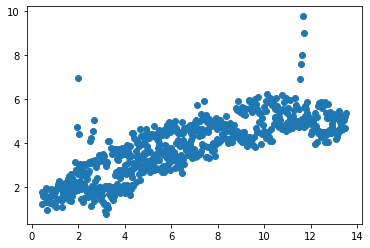

In [16]:
predictions = pd.read_csv('predictions_bgr2rgb.csv', header=None)
gazes = pd.read_csv('actual.csv', header=None)
xgaze = gazes[0]
ygaze = gazes[1]

predictions = np.array(predictions)
# plt.scatter(xgaze,predictions[:,0]*-1)
# plt.plot(xgaze,ygaze)

plt.scatter((ygaze),(predictions[:,1]*-1))


def scale_array(dat, out_range=(-1, 1)):
    domain = [np.min(dat, axis=0), np.max(dat, axis=0)]

    def interp(x):
        return out_range[0] * (1.0 - x) + out_range[1] * x

    def uninterp(x):
        b = 0
        if (domain[1] - domain[0]) != 0:
            b = domain[1] - domain[0]
        else:
            b =  1.0 / domain[1]
        return (x - domain[0]) / b

    return interp(uninterp(dat))



In [17]:
scipy.stats.pearsonr((ygaze),(predictions[:,1]*-1))

(0.8134100083631391, 6.246077219872413e-166)

/hpc/gsin255/pd-hpc6-venv36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='0'>

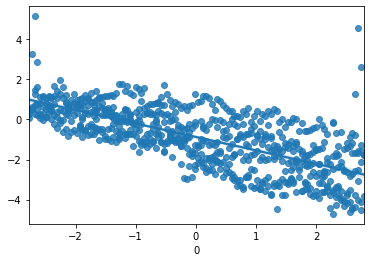

In [40]:
sns.regplot(xgaze, predictions[:,0])

In [35]:
predictions[0]

array([ 0.6658274, -1.3994508])

In [ ]:
pd.DataFrame(predictions).to_csv("predictions_bgr2rgb.csv", index=False, header=False)
pd.DataFrame(errorx).to_csv("errorx_bgr2rgb.csv", index=False, header=False)
pd.DataFrame(errory).to_csv("errory_bgr2rgb.csv", index=False, header=False)
pd.DataFrame({"xgaze":xgaze,"ygaze":ygaze}).to_csv("actual.csv", index=False, header=False)

predictions = np.array(predictions)
plt.plot(xgaze,predictions[:,1]*-1)
# plt.plot(xgaze,ygaze)
# plt.savefig('plot_bgr2rgb.jpg')

In [20]:
directory = "/hpc/gsin255/Datasets/gazecapture_processed/"
for file in os.listdir(directory):
    tempDirectory = os.path.join(directory,file,'appleFace')



# directory = "/hpc/gsin255/Datasets/gazecapture_processed/00002/appleFace"
# directoryLEye = "/hpc/gsin255/Datasets/gazecapture_processed/00002/appleLeftEye"

# import os
# import cv2
# for file in os.listdir("/hpc/gsin255/Datasets/gazecapture_processed/00002/appleFace"):
#     if file.endswith(".jpg"):
#         fileName = os.path.join(directory, file)
#         fileNameEye = os.path.join(directoryLEye, file)
#         img = cv2.imread(fileName)
#         imgLEye = cv2.imread(fileNameEye)
#         print(img.shape[0]/imgLEye.shape[0])

00002
00003
00005
00006
00010
00024
00028
00033
00034
00087
00089
00097
00098
00099
00102
00103
00104
00110
00114
00117
00120
00121
00122
00123
00124
00126
00127
00128
00130
00132
00133
00135
00137
00138
00139
00140
00141
00142
00143
00144
00145
00146
00148
00149
00150
00153
00154
00156
00162
00164
00165
00173
00178
00179
00190
00191
00192
00194
00198
00200
00202
00207
00208
00209
00210
00211
00212
00213
00214
00218
00220
00221
00222
00224
00225
00226
00227
00228
00229
00232
00233
00234
00236
00237
00238
00239
00240
00241
00243
00245
00247
00249
00251
00252
00258
00266
00267
00268
00269
00273
00274
00285
00288
00289
00295
00296
00299
00300
00303
00304
00305
00307
00309
00310
00311
00312
00317
00319
00322
00324
00325
metadata.mat
